# QF605 Part I

###### Prepared By:  

Dani Pangestu  
Gabriel Woon  
Gabriel Tan  
Kenneth Chong  
Peter Chettiar  
Yong Wen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize

**Question 1**

In [2]:
oisData = pd.read_excel("IR Data.xlsx", sheet_name="OIS")

In [3]:
oisData = oisData.drop(columns=['Unnamed: 3', 'Unnamed: 4','Unnamed: 5'])

In [4]:
oisData['Tenor'] = oisData['Tenor'].str[:-1]
oisData.iloc[0, 0] = 0.5
oisData['Tenor'] = oisData['Tenor'].astype(float)
oisData

,Tenor,Product,Rate
0,0.5,OIS,0.00250
1,1.0,OIS,0.00300
2,2.0,OIS,0.00325
3,3.0,OIS,0.00335
4,4.0,OIS,0.00350
5,5.0,OIS,0.00360
6,7.0,OIS,0.00400
7,10.0,OIS,0.00450
8,15.0,OIS,0.00500
9,20.0,OIS,0.00525


its using the overnight rate for each period.. like D(0,2) will be 1/[(1+f0/360)^180 * (1+f1/360)^180 * (1+f2/360)^360]

In [5]:
# functions to help bootstrap discount curve
def discountOis(prev, f, N):
    # prev discounting
    # f = forward Rate
    # N = number of years
    if N < 2:
        n = 0.5
    else:
        n = 1
    return prev * (1 / (1+f/360)**(360*n))

def oisForward(f, N):
    #f = Forward rate
    if N < 2:
        n = 0.5
    else:
        n = 1
    return (1+f/360)**(360*n) - 1

def oisRootSearch(totalDf, prev, fixRate, prevSumFltVal, f, N):
    return (totalDf + discountOis(prev, f, N))* fixRate - prevSumFltVal - discountOis(prev, f, N) * oisForward(f, N)

def oisRootSearchWithoutOis(noOfYears, totalDf, prev, fixRate, prevSumFltVal, f, N):
    
    LHS = totalDf
    RHS = prevSumFltVal
    tempPrev = prev
    
    for i in range (1, noOfYears+1):
        #set N = 2 -> since it annual rate and cumulative to be at 360
        tempDF = discountOis(tempPrev, f, 2)
        LHS += tempDF
        RHS += tempDF * oisForward(f, 2)
        tempPrev = tempDF
    return LHS * fixRate - RHS

In [6]:
oisCompoundedRates = [0]
oisDiscountFactors = []

dataCounterOis = 2 
tempPrevSumFltVal = 0.0
tempPreviousDf = 1.0

# caculating the the daily compounded overnight rate for [0, 6m]
f0 = optimize.brentq(lambda x :discountOis(tempPreviousDf, x, 0.5) * 0.5 * 0.0025 - discountOis(tempPreviousDf, x, 0.5) * 
                     ((1 + x/360)**180 -1), 
                     1e-12, 1)

tempPreviousDf *= (1/(1+f0/360)**180)

# caculating the the daily compounded overnight rate for [6m, 1y]
f1 = optimize.brentq(lambda x :discountOis(tempPreviousDf, x, 1) * 0.003 - discountOis(tempPreviousDf, x, 0.5) * 
                     ((1 + x/360)**180 *(1+f0/360)**180 -1), 
                     1e-12, 1)

tempPrevSumFltVal += discountOis(tempPreviousDf, f1, 1) * ((1 + f1/360)**180 * (1+f0/360)**180 - 1)
tempPreviousDf *= (1/(1+f1/360)**180)
oisDiscountFactors.append(tempPreviousDf)

# appending compounded rate Ft for checking
oisCompoundedRates.append(f1)

# looping to find OIS discount factor from 2 to 30
i = 2
while i < 31:
    
    tempYear = oisData['Tenor'][dataCounterOis]
    
    while ( i > tempYear):
        dataCounterOis += 1
        tempYear = oisData['Tenor'][dataCounterOis]
        
    # getting out the fixed rate to be use for calculation
    tempFixedRate = oisData['Rate'][dataCounterOis]
    
    # accounting for years without OIS rates (assume overnight rate is flat)
    if ( i != tempYear):
        
        numOfYears  = int(tempYear - i + 1)
        
        tempF = optimize.brentq(lambda x :oisRootSearchWithoutOis(numOfYears, sum(oisDiscountFactors), tempPreviousDf, tempFixedRate, tempPrevSumFltVal, x, i), 
                                1e-12, 1)
        
        for j in range (numOfYears):
            # calculating previous flt value
            tempPrevSumFltVal += discountOis(tempPreviousDf, tempF, 2) * oisForward(tempF, 2)

            tempPreviousDf *= (1/(1+tempF/360)**360)

            oisDiscountFactors.append(tempPreviousDf)

            # appending compounded rate Ft for checking
            oisCompoundedRates.append(tempF)
        
        # t loop continue from tempyear
        i = tempYear + 1
        
    
    else :
        #  optimising to find daily compounded overnight rate
        tempF = optimize.brentq(lambda x :oisRootSearch(sum(oisDiscountFactors), tempPreviousDf, tempFixedRate, tempPrevSumFltVal, x, i), 
                                1e-12, 1)

        # calculating previous flt value
        tempPrevSumFltVal += discountOis(tempPreviousDf, tempF, i) * oisForward(tempF, i)

        tempPreviousDf *= (1/(1+tempF/360)**360)

        oisDiscountFactors.append(tempPreviousDf)

        # appending compounded rate Ft for checking
        oisCompoundedRates.append(tempF)
        i += 1

In [7]:
expandedOisDiscountFactors = [1,(1/(1+f0/360)**180)]
for i in range(len(oisDiscountFactors)):
    if i == len(oisDiscountFactors) - 1:
        expandedOisDiscountFactors.append(oisDiscountFactors[-1])
    else:
        temp = oisDiscountFactors[i]
        temp2 = oisDiscountFactors[i+1]
        # interpolate 6mths values for OIS
        temp3 = (temp + temp2) / 2
        expandedOisDiscountFactors.append(temp)
        expandedOisDiscountFactors.append(temp3)

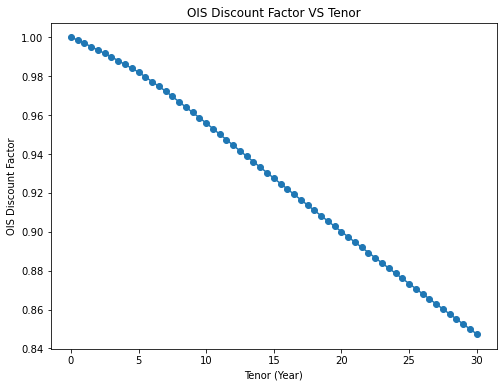

In [8]:
# plot the result
plt.figure(figsize = (8, 6))
plt.plot(np.arange(0, 30.5, 0.5), expandedOisDiscountFactors)
plt.scatter(np.arange(0, 30.5, 0.5), expandedOisDiscountFactors)
plt.xlabel('Tenor (Year)')
plt.ylabel('OIS Discount Factor')
plt.title('OIS Discount Factor VS Tenor')
plt.show()

In [9]:
Discountfactor = pd.DataFrame()
Discountfactor['Tenor'] = np.arange(0,30.5,0.5)
Discountfactor['OISDiscountFactors'] = expandedOisDiscountFactors
Discountfactor

,Tenor,OISDiscountFactors
0,0.0,1.000000
1,0.5,0.998752
2,1.0,0.997009
3,1.5,0.995270
4,2.0,0.993531
...,...,...
56,28.0,0.857703
57,28.5,0.855126
58,29.0,0.852548
59,29.5,0.849986


**Question 2**

In [10]:
irsData = pd.read_excel("IR Data.xlsx", sheet_name="IRS")

In [11]:
irsData = irsData.drop(columns=['Unnamed: 3', 'Unnamed: 4','Unnamed: 5'])

In [12]:
irsData['Tenor'] = irsData['Tenor'].str[:-1]
irsData.iloc[0, 0] = 0.5
irsData['Tenor'] = irsData['Tenor'].astype(float)
irsData

,Tenor,Product,Rate
0,0.5,LIBOR,0.0250
1,1.0,IRS,0.0280
2,2.0,IRS,0.0300
3,3.0,IRS,0.0315
4,4.0,IRS,0.0325
5,5.0,IRS,0.0330
6,7.0,IRS,0.0350
7,10.0,IRS,0.0370
8,15.0,IRS,0.0400
9,20.0,IRS,0.0450


In [13]:
# functions to calculate bootstrap Libor discount
def liborRootSearch(sumOfOis, libfwdRates, fixRate, prevDiscount, dis, yearCount):
    lhs = 0.5 * sum(sumOfOis[1:int(yearCount)*2+1]) * fixRate
    rhs = 0
    limit = len(libfwdRates) - 2
    tempDiff = (prevDiscount - dis) / 2
    tempPrev = prevDiscount
    for j in range(int(yearCount) * 2):
        if j <= limit:
            rhs += 0.5 * sumOfOis[j+1] * libfwdRates[j+1]                            
        else:
            rhs += (tempPrev-(tempPrev - tempDiff))/(tempPrev - tempDiff) * sumOfOis[j+1]
            tempPrev = prevDiscount-tempDiff
    
    return lhs - rhs

def liborRootSearchWithoutIrs(sumOfOis, libfwdRates, noOfSixMths, fixRate, prevDiscount, dis, yearCount):
    lhs = 0.5 * sum(sumOfOis[1:int(yearCount)*2+1]) * fixRate
    rhs = 0
    tempDiff = (prevDiscount - dis) / noOfSixMths
    tempPrev = prevDiscount
    # print(prevDiscount)
    limit = len(libfwdRates)-2
    for j in range(int(yearCount) * 2):
        if j <= limit:
            rhs += 0.5 * sumOfOis[j+1] * libfwdRates[j+1] 
        else:
            test = 2 * sumOfOis[j+1] * (tempPrev-(tempPrev - tempDiff))/(tempPrev - tempDiff) 
            rhs += 0.5 * test
            tempPrev = tempPrev - tempDiff
                  
    return lhs - rhs

def calculateFwdLibor(prevDiscount, discount):
    temp = 2 * (prevDiscount - discount) / discount
    return temp

In [14]:
liborDiscountFactors = [1]
liborForwardRates = [0,0.025]

# calculate [0,6m] discount factor
libDf05 = 1 / (1 + (0.5 * irsData['Rate'][0]))
liborDiscountFactors.append(libDf05)

# calculate [0,1y] discount factor
libDf1 = optimize.brentq(lambda x : 0.5 *(sum(expandedOisDiscountFactors[1:3])) * irsData['Rate'][1] - 0.5 * 
                         irsData['Rate'][0] * expandedOisDiscountFactors[1] - 0.5 * (2*(libDf05-x)/x) * expandedOisDiscountFactors[2], 
                         1e-12, 1)

liborDiscountFactors.append(libDf1)

# appending libforFwd for [6m,1y]
liborForwardRates.append(2*(libDf05-libDf1)/libDf1)

dataCounterLib = 2 
tempPrevSumFltVal = 0.0
tempPreviousDf = 1.0

i = 2
while i < 31:
    tempYear = irsData['Tenor'][dataCounterLib]

    while ( i > tempYear):
        
        dataCounterLib += 1
        tempYear = irsData['Tenor'][dataCounterLib]
        
    # getting out the fixed rate to be use for calculation
    tempFixedRate = irsData['Rate'][dataCounterLib]
    
    # getting the last libor discount factor
    previousDiscount = liborDiscountFactors[-1]
    tempDiff = 0
    # accounting for years without IRS rates (assume discount rate decrease linearly till the next known point)
    if ( i != tempYear):
        noOfSixMths  = int((tempYear - i +1) * 2)
        tempDiscount = optimize.brentq(lambda x :liborRootSearchWithoutIrs(expandedOisDiscountFactors, liborForwardRates, noOfSixMths, tempFixedRate, previousDiscount, x, tempYear), 
                                       1e-12, 1)
        
        tempDiff = (previousDiscount - tempDiscount) / noOfSixMths
        for j in range (noOfSixMths):
            # calculating libor discount factor and append 
            previousDiscount = liborDiscountFactors[-1]
            tempDiscount = previousDiscount - tempDiff
            liborDiscountFactors.append(tempDiscount)
            
            # appending libor forward rates
            tempLiborFwd = calculateFwdLibor(previousDiscount, tempDiscount)
            liborForwardRates.append(tempLiborFwd)
        
        # let loop continue from tempYear
        i = tempYear + 1   
        
    else :
        # optimising to find libor discount rate
        tempDiscount = optimize.brentq(lambda x :liborRootSearch(expandedOisDiscountFactors, liborForwardRates, tempFixedRate, previousDiscount, x, tempYear), 
                                       1e-12, 1)
        
        tempDiscount05 = (previousDiscount + tempDiscount) / 2
        
        # appending discount factors to list
        liborDiscountFactors.append(tempDiscount05)
        liborDiscountFactors.append(tempDiscount)
        
        # appending libor forward rates
        liborForwardRates.append(calculateFwdLibor(previousDiscount, tempDiscount05))
        liborForwardRates.append(calculateFwdLibor(tempDiscount05, tempDiscount))

        i += 1

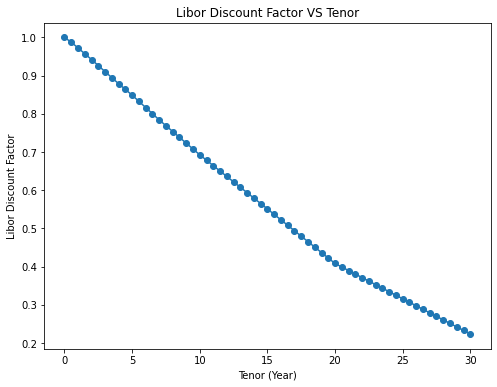

In [15]:
plt.figure(figsize = (8, 6))
plt.plot(np.arange(0, 30.5, 0.5), liborDiscountFactors)
plt.scatter(np.arange(0, 30.5, 0.5), liborDiscountFactors)
plt.xlabel('Tenor (Year)')
plt.ylabel('Libor Discount Factor')
plt.title('Libor Discount Factor VS Tenor')
plt.show()

In [16]:
Discountfactor['LiborDiscountFactors'] = liborDiscountFactors
Discountfactor

,Tenor,OISDiscountFactors,LiborDiscountFactors
0,0.0,1.000000,1.000000
1,0.5,0.998752,0.987654
2,1.0,0.997009,0.972577
3,1.5,0.995270,0.957378
4,2.0,0.993531,0.942179
...,...,...,...
56,28.0,0.857703,0.260568
57,28.5,0.855126,0.251340
58,29.0,0.852548,0.242112
59,29.5,0.849986,0.232884


**Question 3**

In [17]:
# function to calculate forward swap rates
def calForwardSwapRates(start, tenor, oisList, liborFwdList):
    end = start + tenor
    numerator = 0
    denominator = 0.5 * sum(oisList[start*2+1:end*2+1])
    counter = start * 2 + 1
    for i in range (tenor*2):
        numerator += oisList[counter] * liborFwdList[counter] * 0.5
        counter += 1
    return numerator / denominator

In [18]:
fwdSwapRatesDF = pd.DataFrame(columns=["Start", "Tenor", "ForwardSwapRates"])

# respective OIS discount factors and libor forward rate list
oisList = expandedOisDiscountFactors
liborFwdList = liborForwardRates

tenor = [1, 2, 3, 5, 10]
start = [1, 5, 10]
for i in start:
    for j in tenor:
        tempSwapRate  = calForwardSwapRates(i,j,oisList,liborFwdList)
        new_row = {'Start':str(i) + "Y", 'Tenor':str(j) + "Y", 'ForwardSwapRates':tempSwapRate }
        # append row to the dataframe
        fwdSwapRatesDF = fwdSwapRatesDF.append(new_row, ignore_index=True)
        

In [19]:
fwdSwapRatesDF

,Start,Tenor,ForwardSwapRates
0,1Y,1Y,0.032007
1,1Y,2Y,0.033259
2,1Y,3Y,0.034011
3,1Y,5Y,0.035255
4,1Y,10Y,0.038428
5,5Y,1Y,0.039274
6,5Y,2Y,0.040075
7,5Y,3Y,0.040072
8,5Y,5Y,0.041093
9,5Y,10Y,0.043634
